In [3]:
%ls
#%pip install -r requirements.txt --upgrade -q
%pip install tensorflow keras -q

examples/  README.md         setup.py  tensorflow_engram/
LICENSE    requirements.txt  setup.sh


In [4]:
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
from IPython.display import Image
from time import perf_counter as perf_time
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow_engram.layers import Engram
from tensorflow_engram.models import engram_classifier
from tensorflow_engram.utils import HebbianTraceMonitor, plot_hebbian_trace

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

np.random.seed(42)
tf.random.set_seed(42)

In [5]:
%pip install datasets --upgrade -q
from datasets import load_dataset

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incompatible.
torch 2.6

In [6]:
dataset = load_dataset("wikitext", "wikitext-103-v1", split="train")

# Preprocess the dataset
def preprocess_text(text):
    # Tokenize the text
    tokens = text.split()
    # Convert to lowercase
    tokens = [token.lower() for token in tokens]
    return tokens
dataset = dataset.map(lambda x: {'tokens': preprocess_text(x['text'])})

# Create a vocabulary
vocab = set()
for example in dataset:
    vocab.update(example['tokens'])
vocab = sorted(vocab)
vocab_size = len(vocab)
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}

# Convert tokens to indices
def tokens_to_indices(tokens):
    return [word_to_index[token] for token in tokens if token in word_to_index]
dataset = dataset.map(lambda x: {'indices': tokens_to_indices(x['tokens'])})

# Create sequences
def create_sequences(indices, seq_length=32):
    sequences = []
    for i in range(0, len(indices) - seq_length, seq_length):
        sequences.append(indices[i:i + seq_length])
    return sequences
dataset = dataset.map(lambda x: {'sequences': create_sequences(x['indices'])})

# Flatten the dataset
dataset = dataset.map(lambda x: {'sequences': [item for sublist in x['sequences'] for item in sublist]})

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/722k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/655k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Map:   0%|          | 0/1801350 [00:00<?, ? examples/s]

In [7]:
from keras.preprocessing.sequence import pad_sequences

X_train, X_test = train_test_split(dataset['sequences'], test_size=0.2, random_state=42)

# Pad sequences to ensure uniform length
max_sequence_length = 32
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

X_train = np.array(X_train).astype(np.float32)
X_test = np.array(X_test).astype(np.float32)

# Reshape the data to fit the model
X_train = X_train.reshape(-1, max_sequence_length, 1)  # 32 time steps, each with 1 feature
X_test = X_test.reshape(-1, max_sequence_length, 1)

# Apply scaler for additional normalization
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# Shift the target sequences by one time step
y_train = np.roll(X_train, shift=-1, axis=1)
y_test = np.roll(X_test, shift=-1, axis=1)

# Flatten the target sequences
y_train = y_train.reshape(-1)  # (batch_size * sequence_length,)
y_test = y_test.reshape(-1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ engram (Engram)                 │ (None, 128)            │       214,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 229463)         │    29,600,727 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,814,999 (113.74 MB)

 Trainable params: 29,806,807 (113.70 MB)

 Non-trainable params: 8,192 (32.00 KB)

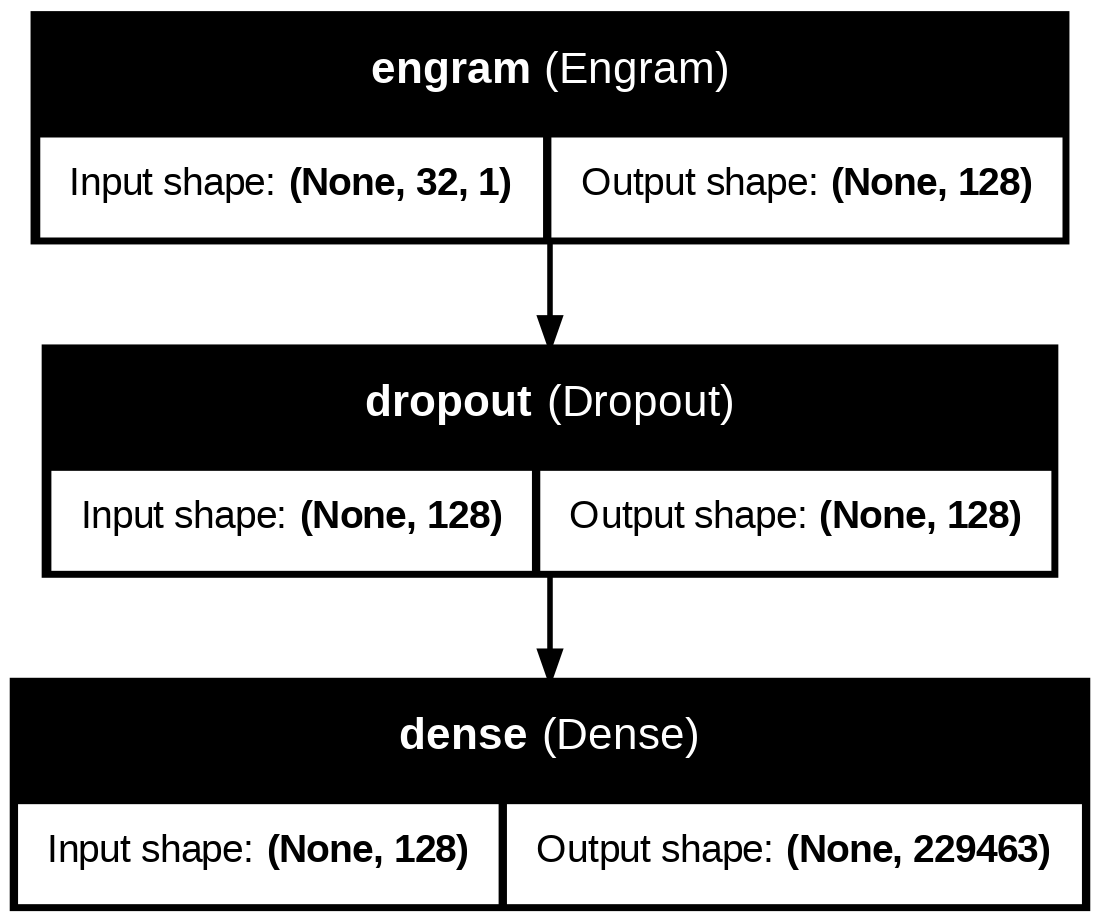

In [8]:
# Create the model
model = engram_classifier(
    input_shape=(32, 1),
    hidden_dim=128,
    memory_size=64,
    num_classes=vocab_size,
    return_states=True,
    sparsity_strength=0.3,
    hebbian_lr=0.05  # Higher learning rate for Hebbian updates
)

trace_callback = HebbianTraceMonitor(
    X_train[:32],
    log_dir="examples/out/wikitext_hebbian_trace",
    verbose=1,
    plot_every=100,
    skip_first_plot=True
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

# Compile and train the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/wikitext_model.png')
#Image(filename='examples/out/wikitext_model.png', width=800)

In [9]:
# Train the model
start_time = perf_time()
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[trace_callback, early_stopping, lr_scheduler]
)
end_time = perf_time()
print(f"Training time: {end_time - start_time:.2f} seconds")

HebbianTraceMonitor initialized.
Epoch 1/10
18014/18014 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6076 - loss: 0.1840
Hebbian trace [Epoch 1] - min: -0.0180, max: 0.0775, mean abs: 0.0084, sparsity: 78.78%
Saved Hebbian trace visualization to examples/out/wikitext_hebbian_trace/hebbian_trace_epoch1_20250522-184057.png
18014/18014 ━━━━━━━━━━━━━━━━━━━━ 252s 13ms/step - accuracy: 0.6076 - loss: 0.1839 - val_accuracy: 0.6072 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
18012/18014 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6087 - loss: 2.2817e-09
Hebbian trace [Epoch 2] - min: -0.0193, max: 0.0718, mean abs: 0.0083, sparsity: 78.58%
18014/18014 ━━━━━━━━━━━━━━━━━━━━ 221s 12ms/step - accuracy: 0.6087 - loss: 2.2815e-09 - val_accuracy: 0.6072 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
18011/18014 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6087 - loss: 3.1209e-11
Hebbian trace [Epoch 3] - min: -0.0158, max: 0.0694, mean abs: 0.0083, sparsity: 79.63%


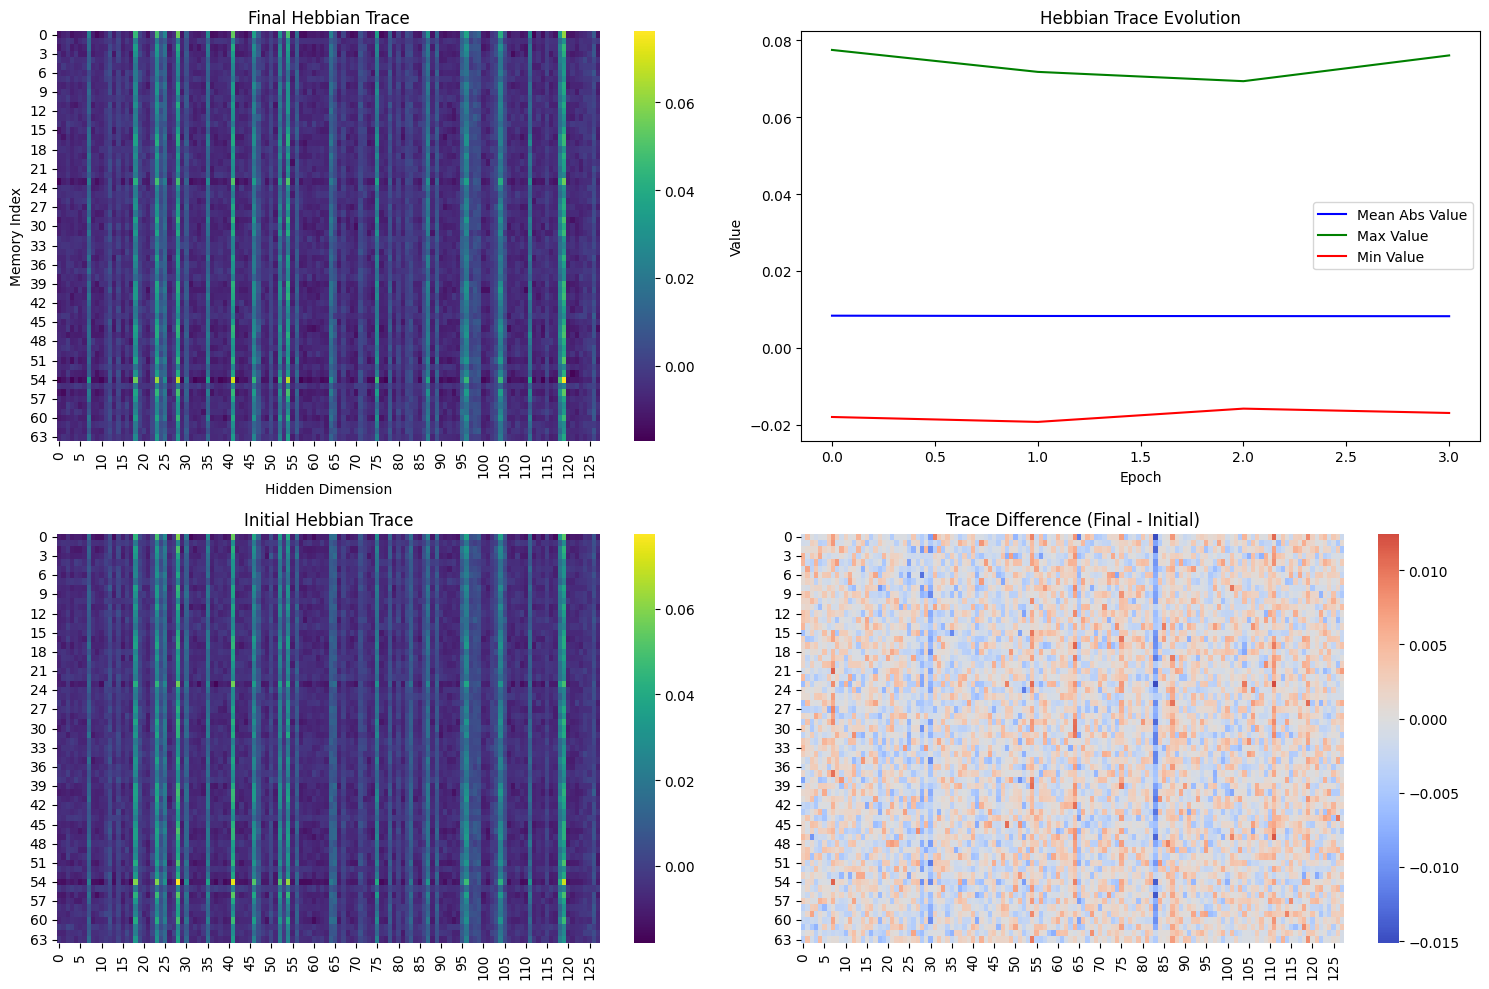

In [10]:
plot_hebbian_trace(trace_callback)  #, file_path='examples/out/hebbian_trace.png')

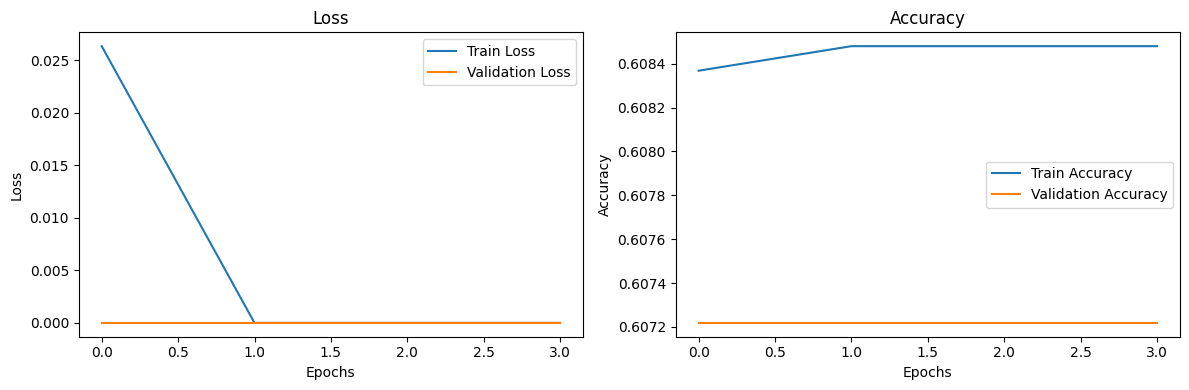

In [11]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('examples/out/wikitext_training_history.png')
plt.show()

## RNN Benchmark

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32, 128)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 229463)         │    29,600,727 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,650,263 (113.11 MB)

 Trainable params: 29,650,263 (113.11 MB)

 Non-trainable params: 0 (0.00 B)

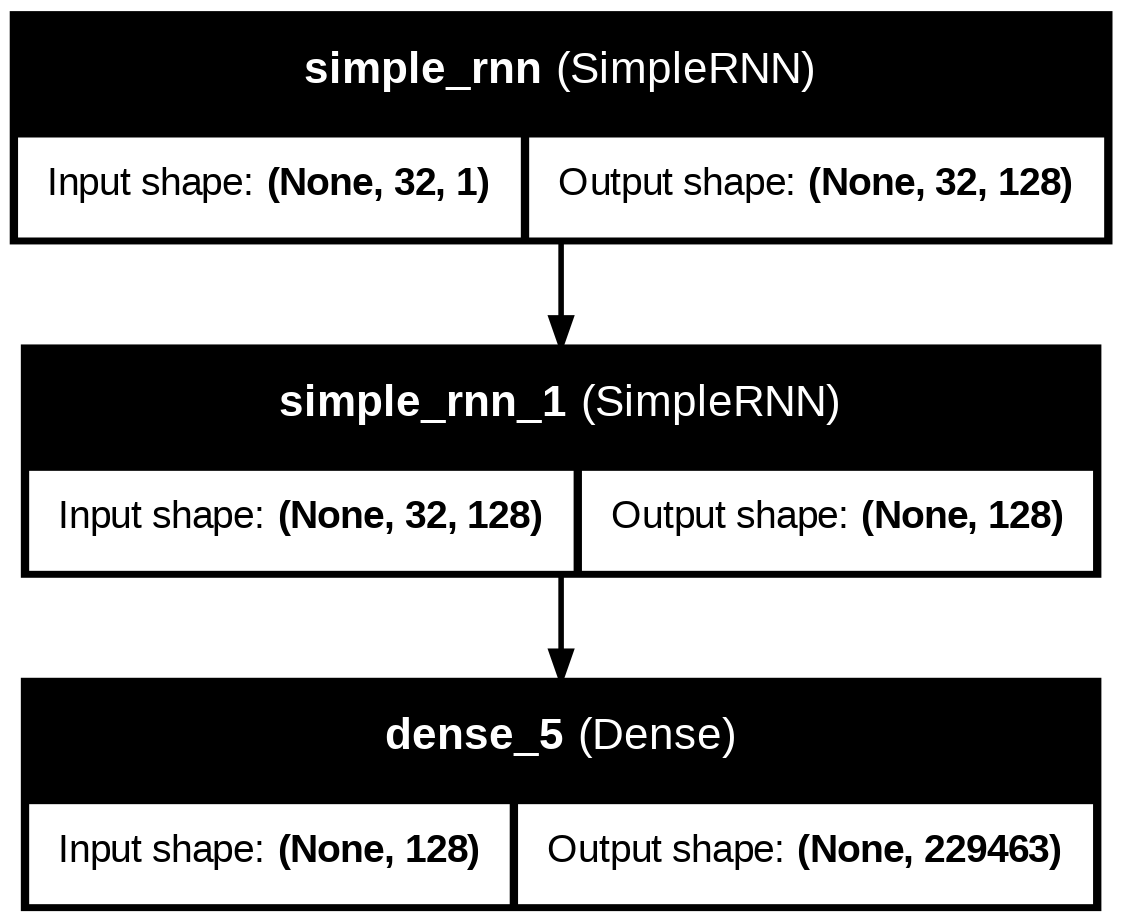

In [12]:
# Create an RNN model that is comparable to the ENN
rnn_model = keras.Sequential([
    keras.layers.SimpleRNN(128, input_shape=(32, 1), return_sequences=True),
    keras.layers.SimpleRNN(128),
    keras.layers.Dense(vocab_size, activation='softmax')
])

rnn_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
rnn_lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

rnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
rnn_model.summary()
plot_model(rnn_model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/wikitext_rnn_model.png')
#Image(filename='examples/out/wikitext_rnn_model.png', width=800

In [13]:
# Train the model
start_time = perf_time()
rnn_history = rnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=64,
    validation_split=0.2,
    callbacks=[rnn_early_stopping, rnn_lr_scheduler]
)
end_time = perf_time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/10
18014/18014 ━━━━━━━━━━━━━━━━━━━━ 175s 9ms/step - accuracy: 0.6082 - loss: 0.1859 - val_accuracy: 0.6072 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/10
18014/18014 ━━━━━━━━━━━━━━━━━━━━ 157s 9ms/step - accuracy: 0.6087 - loss: 0.0000e+00 - val_accuracy: 0.6072 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/10
18014/18014 ━━━━━━━━━━━━━━━━━━━━ 158s 9ms/step - accuracy: 0.6087 - loss: 0.0000e+00 - val_accuracy: 0.6072 - val_loss: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/10
18014/18014 ━━━━━━━━━━━━━━━━━━━━ 157s 9ms/step - accuracy: 0.6087 - loss: 0.0000e+00 - val_accuracy: 0.6072 - val_loss: 0.0000e+00 - learning_rate: 5.0000e-04
Training time: 647.87 seconds


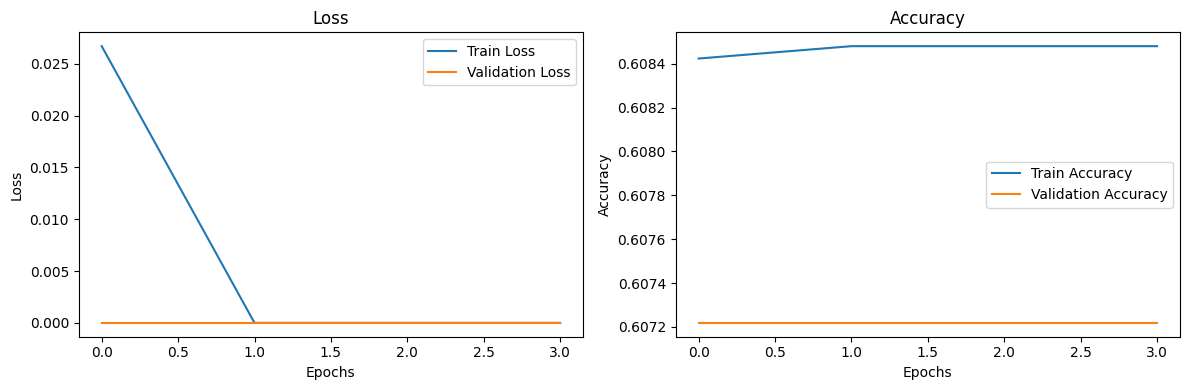

In [14]:
# Plot the training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('examples/out/wikitext_training_history.png')
plt.show()
# Note: 0 Loss Likely Means Softmax Saturation, Not Overfitting